In [602]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, EfficientFrontier, objective_functions
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso 
from sklearn.metrics import r2_score
import seaborn as sns

from matplotlib.ticker import PercentFormatter
sns.reset_defaults()
sns.set_style("whitegrid")

from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='', output_format='pandas')

In [2]:
data, meta_data = ts.get_daily_adjusted(symbol='LREN3.SA', outputsize='full')

In [123]:
# Setting up pipeline
# factor_dict = {}
# Factor exposures:
_etfs = ['IGOV']

for ticker in _etfs:
    temp_data, temp_meta_data = ts.get_daily_adjusted(symbol=ticker, outputsize='full')
    factor_dict[ticker] = temp_data

In [ ]:
# factor_dict

In [366]:
factor_etfs = ['JO','SOYB','WEAT','CORN', 'XLI', 'GOVT','SPY','FEZ','IGOV']

In [367]:
processed_factor_dict = {}

for ticker in factor_etfs:
    temp_df = factor_dict[ticker]
    temp_df['daily return'] = temp_df.loc[:,'5. adjusted close'].pct_change()
    temp_df = temp_df[temp_df.index >= '2016']
    processed_factor_dict[ticker] = temp_df

In [368]:
# Building X dataframe for linear regression:
X = pd.DataFrame(index=data.index)
X = X.sort_index()
for ticker in factor_etfs:
    X[f'{ticker} Daily Returns'] = processed_factor_dict[ticker]['daily return'].sort_index()

X = X.dropna()
# X.sort_index(inplace=True)

In [369]:
X

JO Daily Returns  SOYB Daily Returns  WEAT Daily Returns  \
date                                                                   
2018-02-01          0.009204            0.008291            0.009600   
2018-02-02          0.004727            0.008954            0.009693   
2018-02-05         -0.024369           -0.018559           -0.012759   
2018-02-06          0.000008            0.003891           -0.026398   
2018-02-07         -0.000008           -0.001149            0.010989   
...                      ...                 ...                 ...   
2020-07-28         -0.026879            0.000000           -0.012987   
2020-07-29         -0.026175           -0.002114            0.006536   
2020-07-30         -0.025240           -0.002811           -0.010166   
2020-07-31          0.016170           -0.002104            0.017874   
2020-08-03         -0.031849            0.007062            0.020154   

            CORN Daily Returns  XLI Daily Returns  GOVT Daily Returns  \
date                                                                    
2018-02-01            0.001753           0.020516            0.002035   
2018-02-02            0.007656           0.047548            0.001632   
2018-02-05           -0.012216          -0.017939           -0.004059   
2018-02-06           -0.003478          -0.001843            0.002851   
2018-02-07            0.001161           0.040126           -0.001223   
...                        ...                ...                 ...   
2020-07-28            0.005983          -0.014987           -0.000177   
2020-07-29           -0.002558           0.010139           -0.001770   
2020-07-30            0.000853           0.003764           -0.000177   
2020-07-31           -0.004248          -0.004165            0.000811   
2020-08-03            0.019931          -0.002493           -0.002473   

            SPY Daily Returns  FEZ Daily Returns  IGOV Daily Returns  
date                                                                  
2018-02-01           0.022255           0.026150            0.003132  
2018-02-02           0.043648           0.044024           -0.000392  
2018-02-05          -0.019322          -0.027507            0.005311  
2018-02-06           0.005454           0.019756            0.005141  
2018-02-07           0.038971           0.030411            0.000197  
...                       ...                ...                 ...  
2020-07-28          -0.012149          -0.011546           -0.003562  
2020-07-29           0.003581           0.019529           -0.005963  
2020-07-30          -0.007840           0.022709            0.006377  
2020-07-31          -0.006904          -0.020632            0.001691  
2020-08-03          -0.003848          -0.005330           -0.005047  

[603 rows x 9 columns]

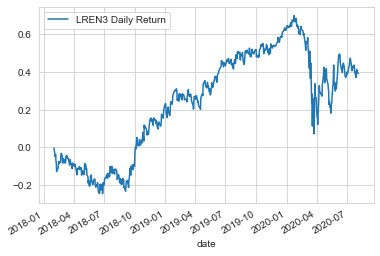

In [503]:
y = pd.DataFrame(index = data.index)
y = y.sort_index()
y['LREN3 Daily Return'] = data.loc[:,'5. adjusted close'].sort_index().pct_change()
etf_df = y.merge(right=X, how='inner', left_index=True, right_index=True)
y = y.loc[etf_df.index]
y.dropna(inplace=True)
X = X.loc[y.index]
X.dropna(inplace=True)
y.cumsum().plot()

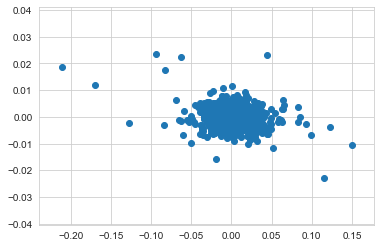

In [502]:
plt.scatter(y, etf_df['IGOV Daily Returns'])

In [372]:
reg = LinearRegression().fit(X,y)
print(reg.coef_)
print(reg.intercept_)

[[ 0.06439609 -0.06349168  0.02843119 -0.16157123 -0.15498377  0.30517839
   0.28959097  0.19554889 -1.63689565]]
[0.00073716]


In [373]:
r2_score(y, reg.predict(X))

0.07874877926535051

In [504]:
etf_df

LREN3 Daily Return  JO Daily Returns  SOYB Daily Returns  \
date                                                                   
2018-02-01           -0.004493          0.009204            0.008291   
2018-02-02           -0.011408          0.004727            0.008954   
2018-02-05           -0.034624         -0.024369           -0.018559   
2018-02-06            0.010843          0.000008            0.003891   
2018-02-07           -0.033278         -0.000008           -0.001149   
...                        ...               ...                 ...   
2020-07-28            0.003750         -0.026879            0.000000   
2020-07-29            0.038605         -0.026175           -0.002114   
2020-07-30           -0.007434         -0.025240           -0.002811   
2020-07-31           -0.006282          0.016170           -0.002104   
2020-08-03           -0.007537         -0.031849            0.007062   

            WEAT Daily Returns  CORN Daily Returns  XLI Daily Returns  \
date                                                                    
2018-02-01            0.009600            0.001753           0.020516   
2018-02-02            0.009693            0.007656           0.047548   
2018-02-05           -0.012759           -0.012216          -0.017939   
2018-02-06           -0.026398           -0.003478          -0.001843   
2018-02-07            0.010989            0.001161           0.040126   
...                        ...                 ...                ...   
2020-07-28           -0.012987            0.005983          -0.014987   
2020-07-29            0.006536           -0.002558           0.010139   
2020-07-30           -0.010166            0.000853           0.003764   
2020-07-31            0.017874           -0.004248          -0.004165   
2020-08-03            0.020154            0.019931          -0.002493   

            GOVT Daily Returns  SPY Daily Returns  FEZ Daily Returns  \
date                                                                   
2018-02-01            0.002035           0.022255           0.026150   
2018-02-02            0.001632           0.043648           0.044024   
2018-02-05           -0.004059          -0.019322          -0.027507   
2018-02-06            0.002851           0.005454           0.019756   
2018-02-07           -0.001223           0.038971           0.030411   
...                        ...                ...                ...   
2020-07-28           -0.000177          -0.012149          -0.011546   
2020-07-29           -0.001770           0.003581           0.019529   
2020-07-30           -0.000177          -0.007840           0.022709   
2020-07-31            0.000811          -0.006904          -0.020632   
2020-08-03           -0.002473          -0.003848          -0.005330   

            IGOV Daily Returns  
date                            
2018-02-01            0.003132  
2018-02-02           -0.000392  
2018-02-05            0.005311  
2018-02-06            0.005141  
2018-02-07            0.000197  
...                        ...  
2020-07-28           -0.003562  
2020-07-29           -0.005963  
2020-07-30            0.006377  
2020-07-31            0.001691  
2020-08-03           -0.005047  

[603 rows x 10 columns]

In [374]:
etf_df.cov()

LREN3 Daily Return  JO Daily Returns  SOYB Daily Returns  \
LREN3 Daily Return            0.000814          0.000027           -0.000002   
JO Daily Returns              0.000027          0.000395            0.000046   
SOYB Daily Returns           -0.000002          0.000046            0.000085   
WEAT Daily Returns           -0.000006          0.000043            0.000052   
CORN Daily Returns           -0.000008          0.000035            0.000057   
XLI Daily Returns             0.000066          0.000039            0.000040   
GOVT Daily Returns           -0.000014         -0.000005           -0.000004   
SPY Daily Returns             0.000067          0.000038            0.000035   
FEZ Daily Returns             0.000054          0.000038            0.000043   
IGOV Daily Returns           -0.000028          0.000001            0.000002   

                    WEAT Daily Returns  CORN Daily Returns  XLI Daily Returns  \
LREN3 Daily Return       -5.794171e-06       -8.386077e-06           0.000066   
JO Daily Returns          4.297225e-05        3.505589e-05           0.000039   
SOYB Daily Returns        5.158685e-05        5.676542e-05           0.000040   
WEAT Daily Returns        2.143055e-04        9.058020e-05           0.000015   
CORN Daily Returns        9.058020e-05        1.161442e-04           0.000035   
XLI Daily Returns         1.479156e-05        3.543923e-05           0.000329   
GOVT Daily Returns       -7.763825e-07       -3.606489e-06          -0.000027   
SPY Daily Returns         1.384928e-05        2.960465e-05           0.000261   
FEZ Daily Returns         2.436020e-05        3.388667e-05           0.000263   
IGOV Daily Returns        1.825857e-06       -3.324808e-07          -0.000002   

                    GOVT Daily Returns  SPY Daily Returns  FEZ Daily Returns  \
LREN3 Daily Return       -1.418934e-05           0.000067           0.000054   
JO Daily Returns         -4.865252e-06           0.000038           0.000038   
SOYB Daily Returns       -3.521369e-06           0.000035           0.000043   
WEAT Daily Returns       -7.763825e-07           0.000014           0.000024   
CORN Daily Returns       -3.606489e-06           0.000030           0.000034   
XLI Daily Returns        -2.720921e-05           0.000261           0.000263   
GOVT Daily Returns        9.648596e-06          -0.000024          -0.000020   
SPY Daily Returns        -2.364982e-05           0.000237           0.000227   
FEZ Daily Returns        -2.031682e-05           0.000227           0.000274   
IGOV Daily Returns        6.720080e-06          -0.000004           0.000008   

                    IGOV Daily Returns  
LREN3 Daily Return       -2.791947e-05  
JO Daily Returns          1.363106e-06  
SOYB Daily Returns        1.886488e-06  
WEAT Daily Returns        1.825857e-06  
CORN Daily Returns       -3.324808e-07  
XLI Daily Returns        -2.413099e-06  
GOVT Daily Returns        6.720080e-06  
SPY Daily Returns        -3.648319e-06  
FEZ Daily Returns         8.389333e-06  
IGOV Daily Returns        1.893946e-05

In [468]:
mu = expected_returns.mean_historical_return(etf_df, returns_data=True)
S = risk_models.sample_cov(etf_df, returns_data=True)

In [487]:
gamma_ctrl = 1

In [608]:
ef_2 = EfficientFrontier(mu, S, weight_bounds=(-1,1))
ef_2.add_objective(objective_functions.L2_reg, gamma=1)

In [498]:
ef_2 = EfficientFrontier(mu, S, weight_bounds=(-1,1))
ef_2.add_objective(objective_functions.L2_reg, gamma=gamma_ctrl)
raw_weights = ef_2.min_volatility()
cleaned_weights = ef_2.clean_weights()
ef_2.save_weights_to_file(f"weights_mv.csv")  # saves to file
ef_2 = EfficientFrontier(mu, S, weight_bounds=(-1,1))
ef_2.add_objective(objective_functions.L2_reg, gamma=gamma_ctrl)
raw_weights = ef_2.max_sharpe()
ef_2.save_weights_to_file(f"weights_sharpe.csv")  # saves to file
ef_2 = EfficientFrontier(mu, S, weight_bounds=(-1,1))
ef_2.add_objective(objective_functions.L2_reg, gamma=gamma_ctrl)
raw_weights = ef_2.max_quadratic_utility()
ef_2.save_weights_to_file(f"weights_mqu.csv")  # saves to file
print(cleaned_weights)
ef_2.portfolio_performance(verbose=True)

OrderedDict([('LREN3 Daily Return', 0.09119), ('JO Daily Returns', 0.09717), ('SOYB Daily Returns', 0.10446), ('WEAT Daily Returns', 0.10185), ('CORN Daily Returns', 0.10356), ('XLI Daily Returns', 0.08968), ('GOVT Daily Returns', 0.11506), ('SPY Daily Returns', 0.09284), ('FEZ Daily Returns', 0.09122), ('IGOV Daily Returns', 0.11297)])
Expected annual return: 11.1%
Annual volatility: 13.2%
Sharpe Ratio: 0.69


C:\Users\raahimsal\Anaconda3\lib\site-packages\pypfopt\efficient_frontier.py:182: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


(0.11050353491683376, 0.13178712293293046, 0.686740349911828)

In [499]:
weights = pd.read_csv('weights_mv.csv')
weight = weights[weights.columns[1]].values
weight = np.insert(weight,0,float(weights.columns[1]))
test = etf_df * weight
test = test.sum(axis=1)
min_vol = test.cumsum()

weights = pd.read_csv('weights_mqu.csv')
weight = weights[weights.columns[1]].values
weight = np.insert(weight,0,float(weights.columns[1]))
test = etf_df * weight
test = test.sum(axis=1)
max_qu = test.cumsum()

weights = pd.read_csv('weights_sharpe.csv')
weight = weights[weights.columns[1]].values
weight = np.insert(weight,0,float(weights.columns[1]))
test = etf_df * weight
test = test.sum(axis=1)
max_sharpe = test.cumsum()

In [584]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=800)
ax.plot(max_sharpe, label='Max Sharpe Ratio')
ax.plot(max_qu, label='Max Quadratic Utility')
ax.plot(min_vol, label='Min Volatility')
ax.plot(y.cumsum(), label='Lojas', alpha=0.5)
ax.legend(loc="upper left")
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Portfolios vs. Company', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.savefig('Portfolio_vs_company.png', bbox_inches='tight')

In [531]:
weights = pd.read_csv('weights_sharpe.csv')
weight = weights[weights.columns[1]].values
weight = np.insert(weight,0,float(weights.columns[1]))
test = etf_df * weight
temp = test.cumsum(axis=0)
wo = temp.iloc[:,1:]

In [588]:
weights['0.24218'].values[0]

0.2522

In [615]:
col_list = []

for index, col in enumerate(wo.columns):
    col_list.append(col.replace('Daily Returns', f'- Weight: {weights["0.24218"].values[index]:.2f}'))

In [616]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=800)
ax.plot(wo, alpha=0.7)
ax.legend(col_list,loc='upper left')
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Constituent Performance of the Max Sharpe Portfolio', fontsize=15)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.savefig('ind_performance.png', bbox_inches='tight')